`Hypothesis Testing in Healthcare: Drug Safety Analysis`

`September 2025`

This project investigates the safety profile of a new drug compared to a placebo using hypothesis testing methods. The analysis focuses on determining whether there are significant differences in adverse effects and demographic characteristics between the two groups.

`Any questions, please reach out!`

Chiawei Wang, PhD\
Data & Product Analyst\
<chiawei.w@outlook.com>

`*` Note that the table of contents and other links may not work directly on GitHub.

[Table of Contents](#table-of-contents)
1. [Executive Summary](#executive-summary)
   - [Challenge](#challenge)
   - [Research Questions](#research-questions)
   - [Data Overview](#data-overview)
   - [Approach](#approach)
   - [Results](#results)
   - [Conclusion](#conclusion)
2. [Exploratory Data Analysis](#exploratory-data-analysis)

# Executive Summary

## Challenge

With the increasing demand for new pharmaceuticals, it is crucial to ensure that new drugs are safe for public consumption. This project aims to analyze data from a randomized controlled drug trial to determine if there are significant adverse effects associated with the drug compared to a placebo.

## Research Questions

1. Does the proportion of adverse effects differ significantly between the Drug and Placebo groups?
2. Is the number of adverse effects independent of the treatment and control groups?
3. Is there a significant difference between the ages of the Drug and Placebo groups?

## Data Overview

| Index | Column            | Type    | Description                                                      |
| ----- | ----------------- | ------- | ---------------------------------------------------------------- |
| 0     | `age`             | int64   | The age of the individual                                        |
| 1     | `sex`             | object  | The gender of the individual                                     |
| 2     | `trx`             | object  | The treatment (Drug) and control (Placebo) groups                |
| 3     | `week`            | int64   | The week of the drug testing                                     |
| 4     | `wbc`             | float64 | The count of white blood cells                                   |
| 5     | `rbc`             | float64 | The count of red blood cells                                     |
| 6     | `adverse_effects` | object  | The presence of at least a single adverse effect                 |
| 7     | `num_effects`     | int64   | The number of adverse effects experienced by a single individual |

## Approach

1. Two-sample proportions z-test
2. Association between adverse effects and the groups
3. Inspecting whether age is normally distributed
4. Significant difference between the ages of both groups

## Results

All p-values fail to reject the null hypothesis at a significance level of 0.05:

1. Adverse effects (z-test) p-value: 0.96
2. Number of adverse effects (Chi-square) p-value: 0.62
3. Age difference (Mann–Whitney U) p-value: 0.26

## Conclusion

Based on the analysis of the drug trial data, there is no significant difference in the proportion of adverse effects between the Drug and Placebo groups. Additionally, the number of adverse effects appears to be independent of the treatment groups. Finally, there is no significant difference in age between the two groups. These findings suggest that the drug does not pose additional risks compared to the placebo in terms of adverse effects and demographic characteristics.

# Exploratory Data Analysis

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import pingouin
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [2]:
# Read in the CSV as a DataFrame
df = pd.read_csv('drugs.csv')

# Preview the data
print(df.shape)
df.head()

(16103, 8)


,age,sex,trx,week,wbc,rbc,adverse_effects,num_effects
0,62,male,Drug,0,7.3,5.1,No,0
1,62,male,Drug,1,NaN,NaN,No,0
2,62,male,Drug,12,5.6,5.0,No,0
3,62,male,Drug,16,NaN,NaN,No,0
4,62,male,Drug,2,6.6,5.1,No,0


Adverse effects (z-test) p-value: 0.96
Number of adverse effects (Chi-square) p-value: 0.62
Age difference (Mann–Whitney U) p-value: 0.26


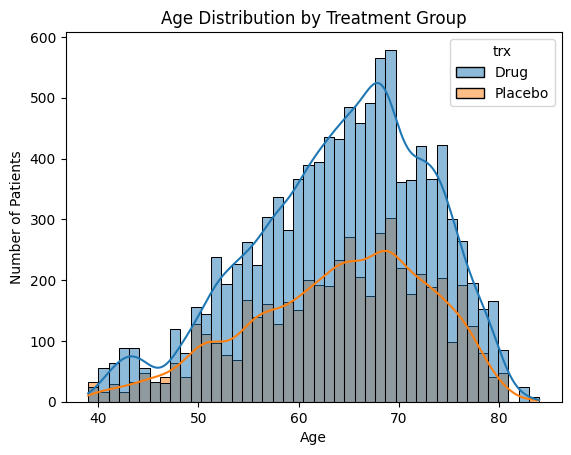

In [3]:
# Count the adverse_effects column values for each trx group
adv_eff_by_trx = df.groupby('trx').adverse_effects.value_counts()

# Compute total rows in each group
adv_eff_by_trx_totals = adv_eff_by_trx.groupby('trx').sum()

# Create an array of the "Yes" counts for each group
yes = [adv_eff_by_trx['Drug']['Yes'], adv_eff_by_trx['Placebo']['Yes']]

# Create an array of the total number of rows in each group
n = [adv_eff_by_trx_totals['Drug'], adv_eff_by_trx_totals['Placebo']]

# Two-sample z-test on the two proportions
two_sample_results = proportions_ztest(yes, n)

# Extract the p-value
two_sample_p_value = two_sample_results[1]

# Collapse rare categories to avoid too-large tables / low counts
df['num_effects_collapsed'] = df['num_effects'].where(df['num_effects'].map(df['num_effects'].value_counts()) > 5, other = 'Other')

# Contingency table
contingency = pd.crosstab(df['num_effects_collapsed'], df['trx'])

# Chi-square test safely (ignoring low-count warnings)
with warnings.catch_warnings():
     warnings.simplefilter('ignore', UserWarning)
     chi2_res = pingouin.chi2_independence(data = df, x = 'num_effects_collapsed', y = 'trx')

# Extract the p-value
num_effects_p_value = chi2_res[2]['pval'].iloc[0]

# Create a histogram with Seaborn
sns.histplot(data = df, x = 'age', hue = 'trx', kde = True)
plt.title('Age Distribution by Treatment Group')
plt.xlabel('Age')
plt.ylabel('Number of Patients')

# To choose between unpaired t-test and Wilcoxon-Mann-Whitney test
max_sample = 5000
sample_df = df.sample(min(len(df), max_sample), random_state = 42)

# Test for normality in each group
normality = pingouin.normality(data = sample_df, dv = 'age', group = 'trx', method = 'shapiro', alpha = 0.05)

# Select the age of the Drug group
age_trx = df.loc[df['trx'] == 'Drug', 'age']

# Select the age of the Placebo group
age_placebo = df.loc[df['trx'] == 'Placebo', 'age']

# Since the data distribution is not normal
# Conduct a two-sided Mann-Whitney U test
age_group_effects = pingouin.mwu(age_trx, age_placebo)

# Extract the p-value
age_group_effects_p_value = age_group_effects['p-val'].iloc[0]

print(f'Adverse effects (z-test) p-value: {two_sample_p_value:.2f}')
print(f'Number of adverse effects (Chi-square) p-value: {num_effects_p_value:.2f}')
print(f'Age difference (Mann–Whitney U) p-value: {age_group_effects_p_value:.2f}')